In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import xgboost as xgb
import numpy as np
from abc import ABC
import optuna, warnings
from data import SingleUSStock, UnEmployRate
from factors import *

/Users/user/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Factor Model With XGBoost And Optuna Optimization**


Introduction
This project focuses on predicting financial market movements using machine learning and historical price data. The goal is to build a pipeline that includes data processing, feature engineering, model training, and hyperparameter optimization using Optuna to find the best performing model while avoiding overfitting.

The process involves the following steps:

1. Data Collection: 
- Historical ETF (Exchange-Traded Funds) data is gathered for SPY, DIA, and QQQ. This data is the foundation for building the predictive model.
2. Feature Engineering: 
- Custom technical indicators (called "factors") are created to extract features from the data. These factors include:

    Moving averages (Cross), Skewness, Slope, Bollinger Bands, Momentum, Volatility, RSI, MACD, Max Drawdown, Price Rank, and more. These factors capture trends, volatility, and other key market dynamics that help the model understand past movements.

3. Dataset Preparation:
    The dataset is split into training and testing sets. To avoid using future data for training, the data is carefully sliced with a time delay.

4. Oversampling: 
- To handle the imbalance between upward and downward market movements, oversampling is applied to the test set. This ensures equal representation of both classes (up and down) and helps the model generalize better to different market conditions.
5. Hyperparameter Optimization with Optuna:
- Optuna is used to automatically search for the best hyperparameters for several models.
- Models optimized include:
    Random Forest
    Lasso Regression and SVM
    XGBoost: A powerful gradient boosting model that is particularly effective for financial data.
6. Model Training and Evaluation:
    The final models are trained on the transformed dataset, and their performance is evaluated on the test set using accuracy and confusion matrices.
This process ensures a robust and optimized model that balances performance and avoids overfitting.

![Flowchart](/Users/user/Desktop/stock/flowchart.png)

In [3]:
df = SingleUSStock().Get()

[*********************100%%**********************]  1 of 1 completed


In [8]:
MACD(20,30).Gen(df[:100])

0.11400023228936952

In [16]:
selected = ['Skewness 10', 'Bolling Band 10', 'Price Rank 5', 'Sharpe Ratio 5','MACD 20 60 9', 'Slope 20', 'MACD 3 8 9', 'Skewness 20', 'Slope 90','Price Rank 10']
models = [
    Cross(20, 60), 
    Skewness(5), Skewness(10),Skewness(20),Skewness(30),
    Slope(3), Slope(10), Slope(20), Slope(90),
    Momentum(10), Momentum(30),
    PriceRank(5), PriceRank(10), PriceRank(30),
    BollingBand(10), BollingBand(20),
    MACD(3, 8), MACD(10, 30), MACD(20, 60), 
    SharpeRatio(5), SharpeRatio(10), SharpeRatio(30), 
    Variance(30), RSI(30),
    UnEmployeeRate(40),
]

models = [mod for mod in models if str(mod) in selected]
model_names = [str(mod) for mod in models]


def add_features(train_x, train_y, test_x, test_y, oversample=True):
    trans_train_x = []
    trans_train_y = []
    trans_test_x = []
    trans_test_y = []
    for (x, y, x2, y2) in zip(train_x, train_y, test_x, test_y):
        val = [model.Gen(x) for model in models]
        trans_train_x.append(val)
        trans_train_y.append(y > 0)
        val = [model.Gen(x2) for model in models]
        trans_test_x.append(val)
        trans_test_y.append(y2 > 0)
    # if oversample:
    #     ros = RandomOverSampler(random_state=42)
    #     trans_test_x, trans_test_y = ros.fit_resample(trans_test_x, trans_test_y)
    return trans_train_x, trans_train_y, trans_test_x, trans_test_y

# trans_train_x, trans_train_y, trans_test_x, trans_test_y = add_features(train_x, train_y, test_x, test_y)





def make_data(X: pd.DataFrame, predict_period: int = 5, delay: int = 66, random: bool = False, test_ratio: float = 0.2):
    assert(sum(X["Adj Close"] <= 0) == 0)
    assert((test_ratio > 0) & (test_ratio < 1))
    Colums = ["Adj Close", "Volume"]
    
    # Calculate the target variable `y` based on `X`
    X["UnEmployRate"] = UnEmployRate("2002", "2025").Get()
    X["UnEmployRate"] = X["UnEmployRate"].ffill()
    X = X.dropna()
    y = X["Adj Close"].apply(np.log).diff(predict_period).shift(-predict_period)
    
    
    train = []
    test = []
    
    # Adjust the loop to avoid using future data
    # print(X.size, y.size)
    for i in range(len(X) - delay - predict_period-1):
        start, end = i, i + delay
        predict = i + delay
        
        # Append the training data and ensure no future information is used
        train.append(X[Colums][start:end])
        test.append(y[predict])  # This is now valid as it only uses current and past data
    
    split_idx = int((1 - test_ratio) * len(train))  # Adjusted to split the dataset
    train_x = train[:split_idx]
    train_y = test[:split_idx]
    test_x = train[split_idx:]
    test_y = test[split_idx:]
    
    return add_features(train_x, train_y, test_x, test_y)
    # return train_x, train_y, test_x, test_y

In [18]:
asset_spy = SingleUSStock(stock_id="SPY").Get()
trans_train_x, trans_train_y, trans_test_x, trans_test_y = make_data(asset_spy, delay=100)

[*********************100%%**********************]  1 of 1 completed


KeyError: 'series'

In [31]:
UnEmployRate("2010", "2012").Get()

{'status': 'REQUEST_NOT_PROCESSED',
 'responseTime': 0,
 'message': ['Request could not be serviced, as the daily threshold for total number of requests allocated to the user with registration key   has been reached.'],
 'Results': {}}

In [15]:
corr = pd.DataFrame(trans_train_x).corrwith(pd.Series(trans_train_y))
corr.index = [str(mod) for mod in models]
factor_ranking = corr.abs().sort_values(ascending=False)
factor_ranking[:10].keys()

Index(['Skewness 10', 'Bolling Band 10', 'Price Rank 5', 'Sharpe Ratio 5',
       'Slope 20', 'MACD 20 60 9', 'MACD 3 8 9', 'Slope 90', 'Skewness 20',
       'Price Rank 10'],
      dtype='object')

In [11]:
pd.DataFrame(trans_train_x).corr()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.645136,0.136205,-0.192518,0.086181,0.153380,0.028336,0.141626,0.135592,0.038381
1,0.645136,1.000000,0.199255,-0.206844,0.119064,0.199174,0.061732,0.175569,0.217529,0.130589
2,0.136205,0.199255,1.000000,0.177641,0.154219,0.356185,0.141697,-0.048835,0.459916,0.306868
3,-0.192518,-0.206844,0.177641,1.000000,-0.007110,-0.000318,-0.027208,-0.072749,-0.105212,0.032473
4,0.086181,0.119064,0.154219,-0.007110,1.000000,0.856246,0.361592,0.665846,0.238341,0.675294
5,0.153380,0.199174,0.356185,-0.000318,0.856246,1.000000,0.377530,0.657933,0.483941,0.791219
6,0.028336,0.061732,0.141697,-0.027208,0.361592,0.377530,1.000000,0.242725,0.161817,0.341740
7,0.141626,0.175569,-0.048835,-0.072749,0.665846,0.657933,0.242725,1.000000,0.164713,0.635346
8,0.135592,0.217529,0.459916,-0.105212,0.238341,0.483941,0.161817,0.164713,1.000000,0.416116
9,0.038381,0.130589,0.306868,0.032473,0.675294,0.791219,0.341740,0.635346,0.416116,1.000000


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create and train the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(trans_train_x, trans_train_y)
    # y_pred = model.predict(trans_test_x)
    y_pred = model.predict(trans_test_x)
    
    return accuracy_score(trans_test_y, y_pred)


def objective(trial):
    model_type = trial.suggest_categorical('model_type', ['Lasso', 'SVM'])
    
    if model_type == 'Lasso':
        # Hyperparameters for Lasso
        alpha = trial.suggest_loguniform('alpha', 1e-4, 1e2)
        
        # Create and train the Lasso model
        model = Lasso(alpha=alpha)
        model.fit(trans_train_x, trans_train_y)
        
        # Make predictions (for regression, threshold for classification)
        y_pred = (model.predict(trans_test_x) > 0.5).astype(int)
        
    elif model_type == 'SVM':
        # Hyperparameters for SVM
        C = trial.suggest_loguniform('C', 1e-4, 1e2)
        kernel_type = trial.suggest_categorical('kernel_type', ["linear", "rbf"])
        
        # Create and train the SVM model
        model = SVC(C=C, kernel=kernel_type, probability=True)
        model.fit(trans_train_x, trans_train_y)
        
        # Make predictions
        y_pred = model.predict(trans_test_x)

    # Return the accuracy score
    return accuracy_score(trans_test_y, y_pred)


def objective(trial):
    # 设置XGBoost参数
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_loguniform("lambda", 1e-5, 10.0),  # L2 正则化
        "alpha": trial.suggest_loguniform("alpha", 1e-5, 10.0),    # L1 正则化
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),  # 控制树的分裂时所需的最小损失减少
    }
    
    # 创建XGBoost模型
    model = xgb.XGBClassifier(**param, use_label_encoder=False)

    # 训练模型
    model.fit(trans_train_x, trans_train_y)

    # 在测试集上进行预测
    # train_preds = model.predict(trans_train_x)
    # train_accuracy = accuracy_score(trans_train_y, train_preds)/
    preds = model.predict(trans_test_x)
    pred_labels = np.rint(preds)

    # 计算准确率
    accuracy = accuracy_score(trans_test_y, pred_labels)
    return accuracy

In [17]:
len(trans_train_x), len(trans_train_y)

(974, 974)

In [18]:
study = optuna.create_study(direction='maximize')
# Optimize the objective function
study.optimize(objective, n_trials=100)
# Print the best hyperparameters and their corresponding accuracy
print("Best Hyperparameters: ", study.best_params)
print("Best Accuracy: ", study.best_value)

[I 2024-10-17 21:44:13,440] A new study created in memory with name: no-name-cb4e3162-1dc9-406a-9dfc-9ca52196308b
[I 2024-10-17 21:44:13,800] Trial 0 finished with value: 0.5254237288135594 and parameters: {'lambda': 0.0025002805668317813, 'alpha': 0.0009331041151538119, 'learning_rate': 0.019284841196471336, 'n_estimators': 269, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.9674156463033954, 'colsample_bytree': 0.7289714718407283, 'gamma': 3.9265461447309145}. Best is trial 0 with value: 0.5254237288135594.
[I 2024-10-17 21:44:14,041] Trial 1 finished with value: 0.511864406779661 and parameters: {'lambda': 0.6928298687919865, 'alpha': 2.171867262781411e-05, 'learning_rate': 0.03252396261305613, 'n_estimators': 116, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.5562716413934943, 'colsample_bytree': 0.8112515384307584, 'gamma': 3.50426816274489}. Best is trial 0 with value: 0.5254237288135594.
[I 2024-10-17 21:44:14,528] Trial 2 finished with value: 0.514406779661017 a

Best Hyperparameters:  {'lambda': 6.713921423053977e-05, 'alpha': 5.595251256250446e-05, 'learning_rate': 0.0018233322735694366, 'n_estimators': 371, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.9634608464967527, 'colsample_bytree': 0.9261183079626372, 'gamma': 0.816182107557818}
Best Accuracy:  0.5567796610169492


In [19]:
model = xgb.XGBClassifier(**study.best_params)
model.fit(trans_train_x, trans_train_y)
predicted = model.predict(trans_test_x)

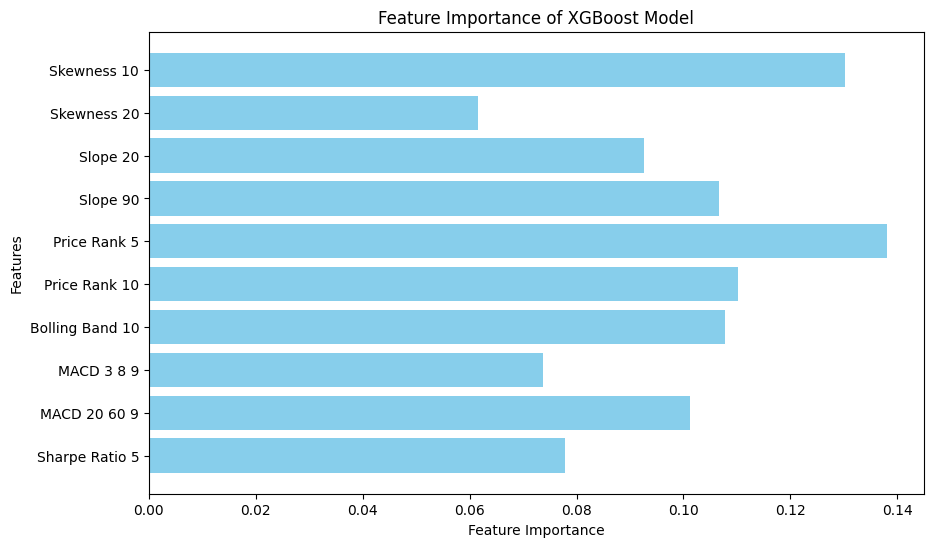

In [20]:
data = dict(zip(model_names, model.feature_importances_))
plt.figure(figsize=(10, 6))
plt.barh(list(data.keys()), data.values(), color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of XGBoost Model')
plt.gca().invert_yaxis()  # 反转 y 轴，使得重要特征在最上方
plt.show()

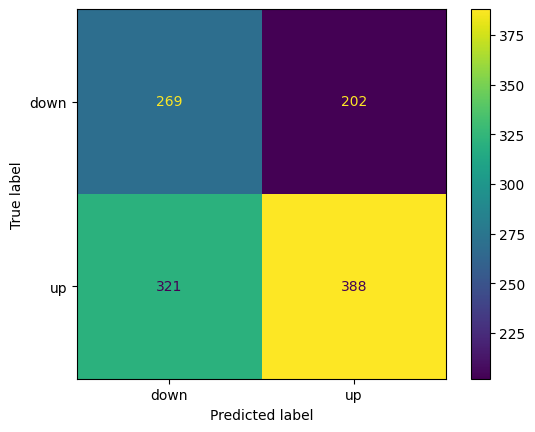

In [21]:
mat = confusion_matrix(predicted, trans_test_y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = mat, display_labels=["down","up"])
cm_display.plot()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


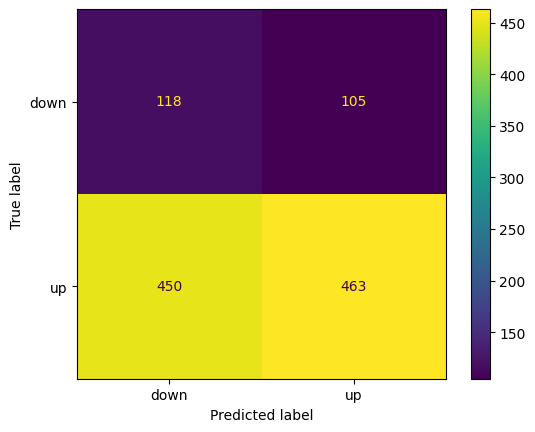

In [28]:
asset_qqq = QQQ()
trans_train_x, trans_train_y, trans_test_x, trans_test_y = make_data(asset_qqq, delay=100)
model = xgb.XGBClassifier(**study.best_params)
model.fit(trans_train_x, trans_train_y)
predicted = model.predict(trans_test_x)

predicted = model.predict(trans_test_x)
mat = confusion_matrix(predicted, trans_test_y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = mat, display_labels=["down","up"])
cm_display.plot()

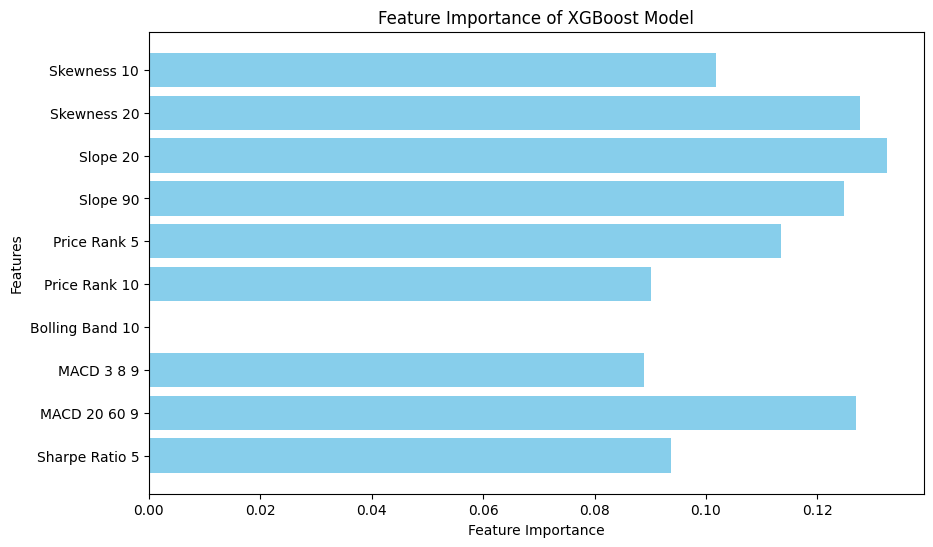

In [23]:
data = dict(zip(model_names, model.feature_importances_))
plt.figure(figsize=(10, 6))
plt.barh(list(data.keys()), data.values(), color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of XGBoost Model')
plt.gca().invert_yaxis()  # 反转 y 轴，使得重要特征在最上方
plt.show()

In [24]:
accuracy_score(predicted, trans_test_y)

0.511443661971831

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


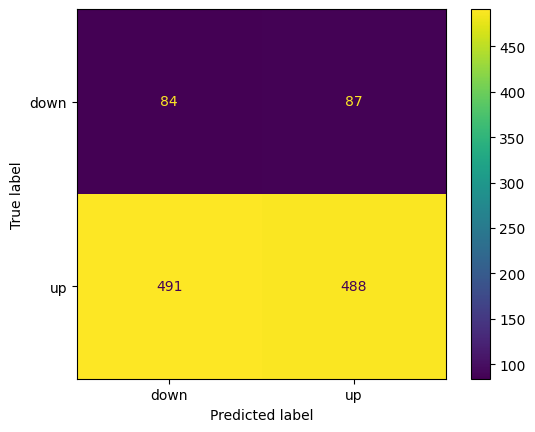

In [32]:
asset_dia = DIA()
trans_train_x, trans_train_y, trans_test_x, trans_test_y = make_data(asset_dia, delay=100)

model = xgb.XGBClassifier(**study.best_params)
model.fit(trans_train_x, trans_train_y)
predicted = model.predict(trans_test_x)

mat = confusion_matrix(predicted, trans_test_y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = mat, display_labels=["down","up"])
cm_display.plot()

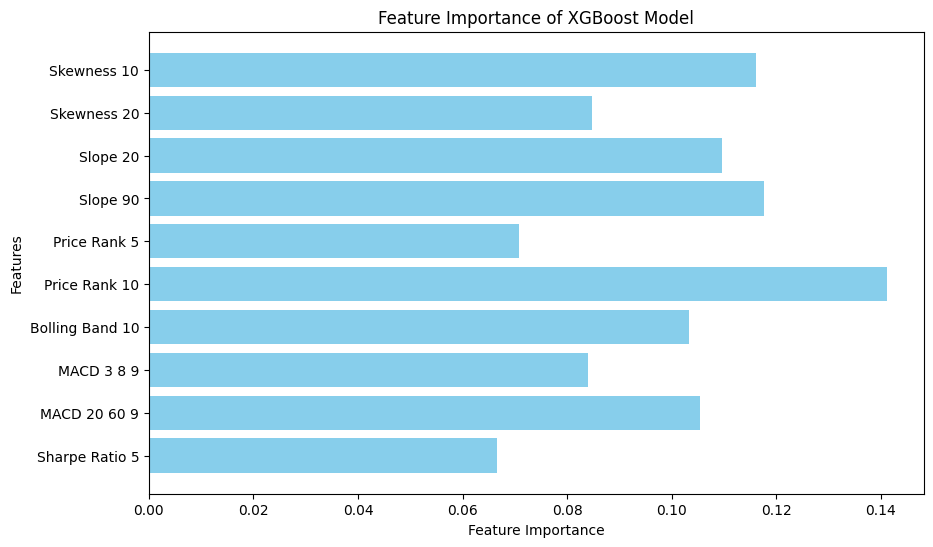

In [33]:
data = dict(zip(model_names, model.feature_importances_))
plt.figure(figsize=(10, 6))
plt.barh(list(data.keys()), data.values(), color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance of XGBoost Model')
plt.gca().invert_yaxis()  # 反转 y 轴，使得重要特征在最上方
plt.show()

In [31]:
accuracy_score(predicted, trans_test_y)

0.4782608695652174